In [384]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.distributions import Categorical

import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import game
import dqn_agent
game = reload(game)
dqn_agent = reload(dqn_agent)
from game import Game
from dqn_agent import DQNAgent

import gym
# env = gym.make('CartPole-v0').unwrapped

In [385]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [386]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [387]:
class Policy(nn.Module):
    def __init__(self, state_size, act_size, hidden_size1, hidden_size2, hidden_size3):
      super(Policy, self).__init__()
      self.act = nn.Sequential(
                                nn.Linear(state_size, hidden_size1),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size1, hidden_size2),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size2, hidden_size3),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size3, act_size),
                               )
        
    def forward(self, X):
      return self.act(X)
    
    def get_parameters(self):
       return self.state_dict()
    
    def set_parameters(self, state_dict):
        self.load_state_dict(state_dict)

In [388]:
state_size = 8
hidden_size1 = 256
hidden_size2 = 50
hidden_size3 = 256
act_size = 3


model = Policy(state_size, act_size, hidden_size1, hidden_size2, hidden_size3).to(device)

In [389]:
batch_size = 100
optimizer = Adam(model.parameters())
loss_func = nn.MSELoss()

dqn = DQNAgent(model, optimizer, loss_func, act_size, 3000, gamma=.99)

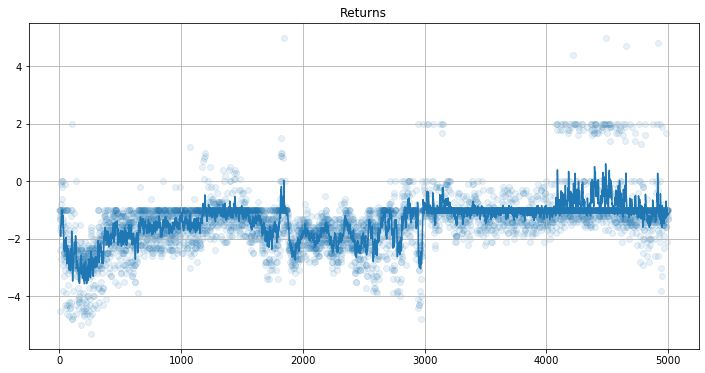

In [390]:
env = Game()
dqn.fit(env, 5000, batch_size, train_every=50, batch_count=3)

In [391]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    # dist = Categorical(probs)
                    # action = dist.sample().item()
                    action = torch.argmax(F.softmax(probs, dim=-1)).item()
            else:
                action = random.randint(0, 2)
            observation, reward, done, _  = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
    env.stop()
                   
    return np.mean(total_reward) 

In [393]:
env = Game(drawing=True)
test_agent(env, agent=model, n_episodes=5)

Episode 1 finished after 28 timesteps
Episode 2 finished after 58 timesteps
Episode 3 finished after 28 timesteps
Episode 4 finished after 28 timesteps
Episode 5 finished after 28 timesteps


-1.5399999999999998